# Introduction

This notebook will take a data-driven approach to generating word lists for mental functions that are related to brain circuitry. The overall process is as follows:

1. Cluster brain structures into circuits by PMI-weighted co-occurrences with mental function terms.
2. Identify the mental function terms most highly associated to each circuit over a range of list lengths.
3. Select the list length for each circuit that maximizes word-structure classification performance. 
4. Select the number of circuits that maximizes circuit-function classification performance.

# Load the data

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append("..")
import utilities, ontology

## Brain activation coordinates

In [2]:
act_bin = pd.read_csv("../data/brain/coordinates_seg.csv", index_col=0)
print("Document N={}, Structure N={}".format(
      act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=148


In [3]:
act_bin.head()

,left_frontal_pole,left_insular_cortex,left_superior_frontal_gyrus,left_middle_frontal_gyrus,left_inferior_frontal_gyrus_pars_triangularis,left_inferior_frontal_gyrus_pars_opercularis,left_precentral_gyrus,left_temporal_pole,left_superior_temporal_gyrus_anterior_division,left_superior_temporal_gyrus_posterior_division,...,right_crus_i,right_crus_ii,right_vermis_crus_i,right_vermis_crus_ii,right_vermis_vi,right_vermis_viib,right_vermis_viiia,right_vermis_viiib,right_vermis_ix,right_vermis_x
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1410086,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1448149,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1486459,1,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1486460,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Terms for mental functions

In [4]:
version = 190325
dtm_bin = utilities.load_doc_term_matrix(version=version, binarize=True)

In [5]:
lexicon = utilities.load_lexicon(["cogneuro"])
lexicon = sorted(list(set(lexicon).intersection(dtm_bin.columns)))
len(lexicon)

1683

In [6]:
dtm_bin = dtm_bin[lexicon]
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=1683


## Document splits

In [7]:
train, val = [[int(pmid.strip()) 
               for pmid in open("../data/splits/{}.txt".format(split))] 
                    for split in ["train", "validation"]]
print("Training N={}, Validation N={}".format(len(train), len(val)))

Training N=12708, Validation N=3631


# Link structures to functions

Links are computed as PMI-weighted co-occurrences across the training set

In [8]:
import numpy as np

In [9]:
stm = ontology.load_stm(act_bin.loc[train], dtm_bin.loc[train])
print("Structure N={}, Term N={}".format(stm.shape[0], stm.shape[1]))

Structure N=148, Term N=1634


# Generate the ontology

## 1. Cluster brain structures by functions

In [10]:
import os
from sklearn.cluster import KMeans
from scipy.stats import pointbiserialr

In [11]:
n_circuits = range(2, 26) # Range over which ROC-AUC becomes asymptotic
list_lens = range(5, 26) # Same range as RDoC and the DSM

In [12]:
for k in n_circuits:
    circuit_file = "circuits/seg/circuits_k{:02d}.csv".format(k)
    if not os.path.isfile(circuit_file):
        kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=42)  
        kmeans.fit(stm)
        clust = pd.DataFrame({"STRUCTURE": act_bin.columns, 
                              "CLUSTER": [l+1 for l in list(kmeans.labels_)]})
        clust = clust.sort_values(["CLUSTER", "STRUCTURE"])
        clust.to_csv(circuit_file, index=None)

## 2. Identify associated terms for mental functions

In [13]:
for k in n_circuits:
    circuit_file = "circuits/seg/circuits_k{:02d}.csv".format(k)
    clust = pd.read_csv(circuit_file, index_col=None)
    list_file = "lists/seg/lists_k{:02d}.csv".format(k)
    if not os.path.isfile(list_file):
        lists = pd.DataFrame()
        for i in range(k):
            structures = list(clust.loc[clust["CLUSTER"] == i+1, "STRUCTURE"])
            centroid = np.mean(act_bin.loc[train, structures], axis=1)
            R = pd.Series([pointbiserialr(dtm_bin.loc[train, word], centroid)[0] 
                           for word in dtm_bin.columns], index=dtm_bin.columns)
            R = R[R > 0].sort_values(ascending=False)[:max(list_lens)]
            R = pd.DataFrame({"CLUSTER": [i+1 for l in range(max(list_lens))], 
                              "TOKEN": R.index, "R": R.values})
            lists = lists.append(R)
        lists.to_csv(list_file, index=None)

## 3. Select number of words per domain

Word list lengths were selected by mean ROC-AUC of forward and reverse classifiers for each circuit. The number of circuits will be selected across values of k using the lists of optimized length, this time training classifiers that use all the circuits at that k. All classifiers were optimized over a grid search for regularization strength, penalty, and intercept.

## 4. Select optimal number of domains

### Circuit-level features

In [14]:
import pickle
from sklearn.preprocessing import binarize

In [15]:
directions = ["forward", "reverse"]

In [16]:
fits = {}
for d in directions:
    fits[d] = {}
    for k in n_circuits:
        fit_file = "logistic_regression/sherlock_seg/fits/{}_k{:02d}_{}.p".format(d, k, d)
        fits[d][k] = pickle.load(open(fit_file, "rb"))

/anaconda3/envs/ontol/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.21.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/envs/ontol/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.21.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/envs/ontol/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator OneVsRestClassifier from version 0.21.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [17]:
features = {k: {} for k in n_circuits}
for k in n_circuits:
    domains = range(1, k+1)
    lists, circuits = ontology.load_ontology(k, suffix="_logreg", cerebellum="seg")
    function_features = pd.DataFrame(index=dtm_bin.index, columns=domains)
    structure_features = pd.DataFrame(index=act_bin.index, columns=domains)
    for i in domains:
        functions = lists.loc[lists["CLUSTER"] == i, "TOKEN"]
        function_features[i] = dtm_bin[functions].sum(axis=1)
        structures = circuits.loc[circuits["CLUSTER"] == i, "STRUCTURE"]
        structure_features[i] = act_bin[structures].sum(axis=1)
    function_features = pd.DataFrame(utilities.doc_mean_thres(function_features), 
                                     index=dtm_bin.index, columns=domains)
    structure_features = pd.DataFrame(binarize(structure_features), 
                                     index=act_bin.index, columns=domains)
    features[k]["function"] = function_features
    features[k]["structure"] = structure_features

### Area under the receiver operating characteristic curve (ROC-AUC)

In [18]:
import math
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [19]:
stats = {}

In [20]:
stats["scores"] = ontology.compute_eval_scores("lr", roc_auc_score, directions, 
                                               n_circuits, features, fits, val)

In [21]:
stats["boot"] = ontology.compute_eval_boot("lr", roc_auc_score, directions, 
                                           n_circuits, features, fits, val, n_iter=1000, 
                                           cerebellum="seg")

In [22]:
stats["null"] = ontology.compute_eval_null("lr", roc_auc_score, directions, 
                                           n_circuits, features, fits, val, n_iter=1000,
                                           cerebellum="seg")

In [23]:
directions += ["mean"]
shapes = [">", "<", "D"]
op_k = 6

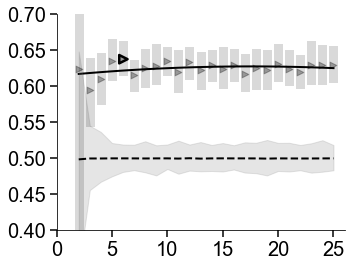

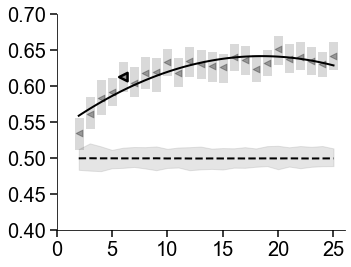

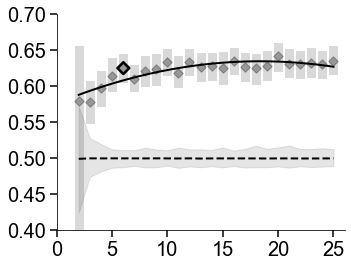

In [24]:
for direction, shape in zip(directions, shapes):
    ontology.plot_scores(direction, n_circuits, stats, shape=shape, ylim=[0.45,0.7], 
                         yticks=np.arange(0.4,0.75,0.05), op_k=op_k, interval=0.999,
                         cerebellum="seg")

# Name the domains

In [25]:
lists, circuits = ontology.load_ontology(op_k, suffix="_logreg", cerebellum="seg")

In [26]:
k2name = {}
for k in range(op_k):
    degrees = ontology.term_degree_centrality(k+1, lists, dtm_bin, train)
    name = degrees.index[0].upper()
    k2name[k+1] = name
print("\n".join(["{}: {}".format(k, name) for k, name in k2name.items()]))

1: HEARING
2: VISION
3: MOVEMENT
4: REWARD
5: MEMORY
6: COGNITIVE


## Export ontology with domain names

In [27]:
order = [5,4,6,3,2,1]
names = [k2name[k] for k in order]
k2order = {k: order.index(k)+1 for k in range(1,op_k+1)}

### Function term lists

In [28]:
columns = ["ORDER", "CLUSTER", "DOMAIN", "TOKEN", "R", "ROC_AUC"]
lists["ORDER"] = [k2order[k] for k in lists["CLUSTER"]]
lists["DOMAIN"] = [k2name[k] for k in lists["CLUSTER"]]
lists = lists.sort_values(["ORDER", "R"], ascending=[True, False])
lists = lists[columns]
lists.to_csv("lists/lists_data-driven_lr_seg.csv", index=None)
lists.head()

,ORDER,CLUSTER,DOMAIN,TOKEN,R,ROC_AUC
55,1,5,MEMORY,memory,0.193057,0.652948
56,1,5,MEMORY,episodic_memory,0.169026,0.652948
57,1,5,MEMORY,declarative_memory,0.165258,0.652948
58,1,5,MEMORY,recognition_memory,0.160612,0.652948
59,1,5,MEMORY,remembering,0.157557,0.652948


### Brain circuits

In [29]:
columns = ["ORDER", "CLUSTER", "DOMAIN", "STRUCTURE"]
circuits["ORDER"] = [k2order[k] for k in circuits["CLUSTER"]]
circuits["DOMAIN"] = [k2name[k] for k in circuits["CLUSTER"]]
circuits = circuits.sort_values(["ORDER", "STRUCTURE"])
circuits = circuits[columns]
circuits.to_csv("circuits/clusters_data-driven_lr_seg.csv", index=None)
circuits.head()

,ORDER,CLUSTER,DOMAIN,STRUCTURE
104,1,5,MEMORY,left_amygdala
105,1,5,MEMORY,left_brainstem
106,1,5,MEMORY,left_hippocampus
107,1,5,MEMORY,left_inferior_temporal_gyrus_anterior_division
108,1,5,MEMORY,left_inferior_temporal_gyrus_posterior_division


In [30]:
circuit_mat = pd.DataFrame(0.0, index=act_bin.columns, columns=names)
for name in names:
    structures = circuits.loc[circuits["DOMAIN"] == name, "STRUCTURE"]
    for structure in structures:
        circuit_mat.loc[structure, name] = 1.0
circuit_mat.to_csv("circuits/circuits_data-driven_lr_seg.csv")
circuit_mat.head()

,MEMORY,REWARD,COGNITIVE,MOVEMENT,VISION,HEARING
left_frontal_pole,0.0,0.0,1.0,0.0,0.0,0.0
left_insular_cortex,0.0,0.0,1.0,0.0,0.0,0.0
left_superior_frontal_gyrus,0.0,0.0,0.0,0.0,1.0,0.0
left_middle_frontal_gyrus,0.0,0.0,0.0,0.0,1.0,0.0
left_inferior_frontal_gyrus_pars_triangularis,0.0,0.0,1.0,0.0,0.0,0.0


# Visualize the term lists

In [31]:
from style import style
%matplotlib inline

MEMORY


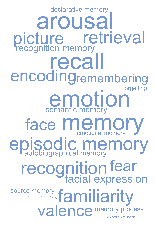

REWARD


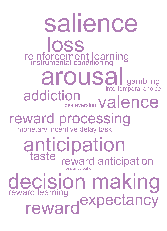

COGNITIVE


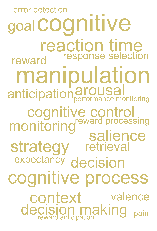

MOVEMENT


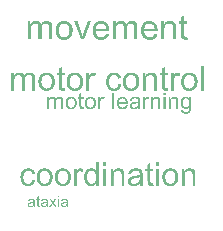

VISION


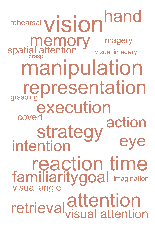

HEARING


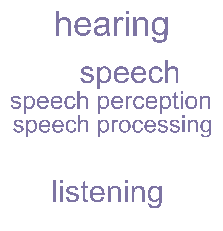

In [32]:
ontology.plot_wordclouds("data-driven", names, lists, dtm_bin, width=600, cerebellum="seg", clf="lr")

# Visualize the circuits

In [33]:
%matplotlib inline

In [34]:
atlas = utilities.load_atlas(cerebellum="seg")

/anaconda3/envs/ontol/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [35]:
purples = style.make_cmap([(1,1,1), (0.365,0,0.878)])
magentas = style.make_cmap([(1,1,1), (0.620,0,0.686)])
yellows = style.make_cmap([(1,1,1), (0.937,0.749,0)])
cmaps = ["Blues", magentas, yellows, "Greens", "Reds", purples, "Oranges"]


MEMORY


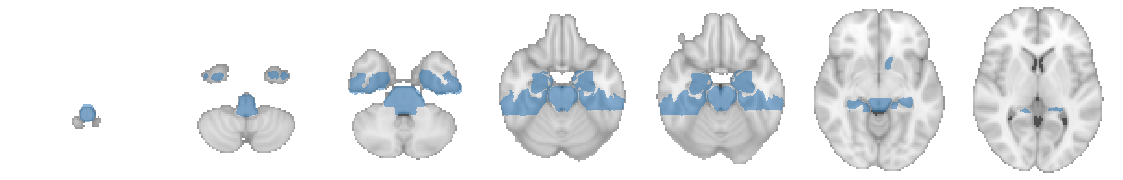


REWARD


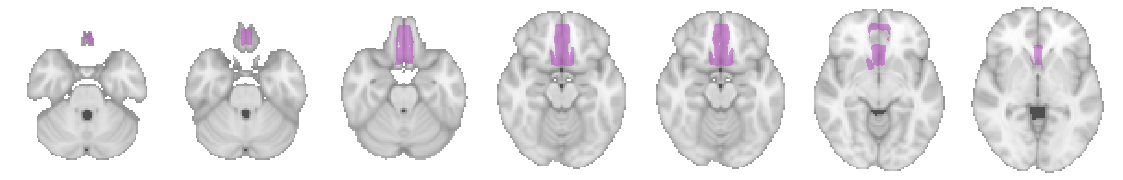


COGNITIVE


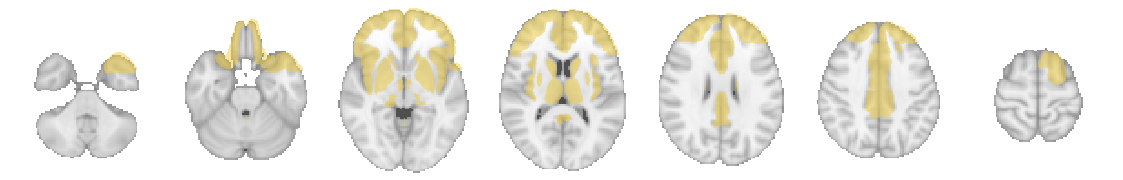


MOVEMENT


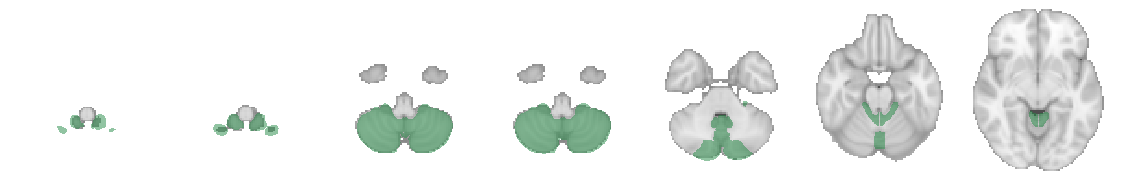


VISION


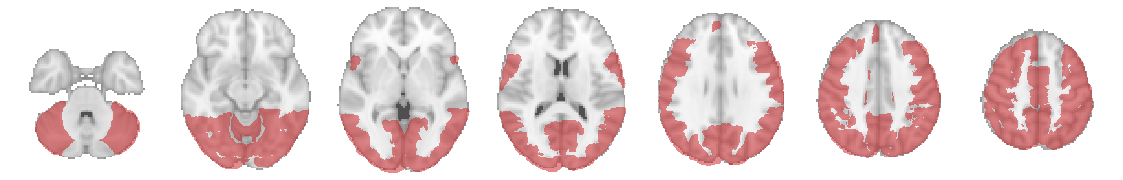


HEARING


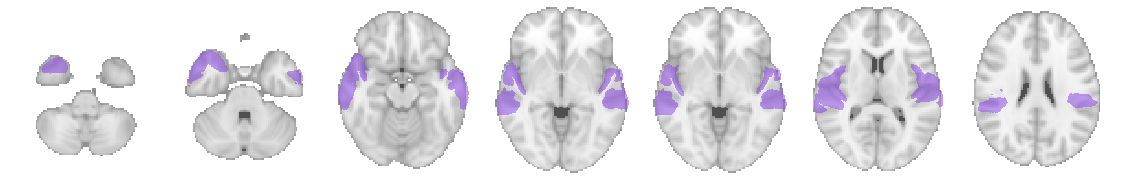

In [36]:
utilities.map_plane(circuit_mat, atlas, "figures/circuits/data-driven_lr_seg", 
                    suffix="_z", cmaps=cmaps, plane="z", cbar=False, vmin=0.0, vmax=2.0,
                    verbose=False, print_fig=True, annotate=False)

In [37]:
for plane in ["x", "y"]:
    utilities.map_plane(circuit_mat, atlas, "figures/circuits/data-driven_lr_seg", 
                        suffix="_"+plane, cmaps=cmaps, plane=plane, cbar=False, vmin=0.0, vmax=2.0,
                        verbose=False, print_fig=False, annotate=False)